In [15]:
import re
import pandas as pd
from datetime import datetime
import os

def parse_scsn_catalog_file(file_path):
    pattern = re.compile(
        r'(\d{4}) (\d{2}) (\d{2})\s+(\d{2}) (\d{2}) ([\d.]+)\s+(\d{2})\s+([\d.]+)-(\d{3})\s+([\d.]+)\s+\w\s+([\d.]+)\s+([\d.-]+).*?(\d+)$'
    )
    records = []

    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                try:
                    year, month, day = int(match.group(1)), int(match.group(2)), int(match.group(3))
                    hour, minute = int(match.group(4)), int(match.group(5))
                    second = float(match.group(6))
                    if second >= 60:
                        continue
                    lat_deg, lat_min = int(match.group(7)), float(match.group(8))
                    lon_deg, lon_min = int(match.group(9)), float(match.group(10))
                    magnitude = float(match.group(11))
                    depth = float(match.group(12))
                    evid = int(match.group(13))

                    latitude = lat_deg + lat_min / 60
                    longitude = -(lon_deg + lon_min / 60)
                    dt = datetime(year, month, day, hour, minute, int(second), int((second % 1) * 1e6))

                    records.append((dt, latitude, longitude, depth, magnitude, evid))
                except Exception:
                    continue
    return records

def parse_all_scsn_catalogs(input_dir, output_csv):
    all_records = []
    for filename in sorted(os.listdir(input_dir)):
        if filename.endswith(".catalog"):
            file_path = os.path.join(input_dir, filename)
            print(f"Parsing {file_path}...")
            all_records.extend(parse_scsn_catalog_file(file_path))

    df = pd.DataFrame(all_records, columns=["time", "latitude", "longitude", "depth", "magnitude", "evid"])
    df.to_csv(output_csv, index=False)
    print(f"All data saved to {output_csv}")

# Example usage:
parse_all_scsn_catalogs("data/SCSN", "all_data.csv")

Parsing data/SCSN/1932.catalog...
Parsing data/SCSN/1933.catalog...
Parsing data/SCSN/1934.catalog...
Parsing data/SCSN/1935.catalog...
Parsing data/SCSN/1936.catalog...
Parsing data/SCSN/1937.catalog...
Parsing data/SCSN/1938.catalog...
Parsing data/SCSN/1939.catalog...
Parsing data/SCSN/1940.catalog...
Parsing data/SCSN/1941.catalog...
Parsing data/SCSN/1942.catalog...
Parsing data/SCSN/1943.catalog...
Parsing data/SCSN/1944.catalog...
Parsing data/SCSN/1945.catalog...
Parsing data/SCSN/1946.catalog...
Parsing data/SCSN/1947.catalog...
Parsing data/SCSN/1948.catalog...
Parsing data/SCSN/1949.catalog...
Parsing data/SCSN/1950.catalog...
Parsing data/SCSN/1951.catalog...
Parsing data/SCSN/1952.catalog...
Parsing data/SCSN/1953.catalog...
Parsing data/SCSN/1954.catalog...
Parsing data/SCSN/1955.catalog...
Parsing data/SCSN/1956.catalog...
Parsing data/SCSN/1957.catalog...
Parsing data/SCSN/1958.catalog...
Parsing data/SCSN/1959.catalog...
Parsing data/SCSN/1960.catalog...
Parsing data/S

Epoch 0: Total Loss = 19521.2422, Data = 19519.2031, Phys = 20.3843
Epoch 200: Total Loss = 16987.8516, Data = 16961.5625, Phys = 262.8886
Epoch 400: Total Loss = 15637.3594, Data = 15568.4785, Phys = 688.8048
Epoch 600: Total Loss = 14686.1582, Data = 14595.1797, Phys = 909.7836
Epoch 800: Total Loss = 13951.8604, Data = 13914.3623, Phys = 374.9844
Epoch 1000: Total Loss = 13470.9912, Data = 13433.7461, Phys = 372.4540
Epoch 1200: Total Loss = 12280.1650, Data = 12211.7354, Phys = 684.2957
Epoch 1400: Total Loss = 11306.9395, Data = 11180.3643, Phys = 1265.7500
Epoch 1600: Total Loss = 10604.3340, Data = 10443.6895, Phys = 1606.4484
Epoch 1800: Total Loss = 9942.5928, Data = 9760.1211, Phys = 1824.7123
Epoch 2000: Total Loss = 9351.2256, Data = 9140.1289, Phys = 2110.9661
Epoch 2200: Total Loss = 8788.5625, Data = 8551.8818, Phys = 2366.8093
Epoch 2400: Total Loss = 8301.2637, Data = 8028.6230, Phys = 2726.4067
Epoch 2600: Total Loss = 7804.5391, Data = 7511.6792, Phys = 2928.6003
Epo

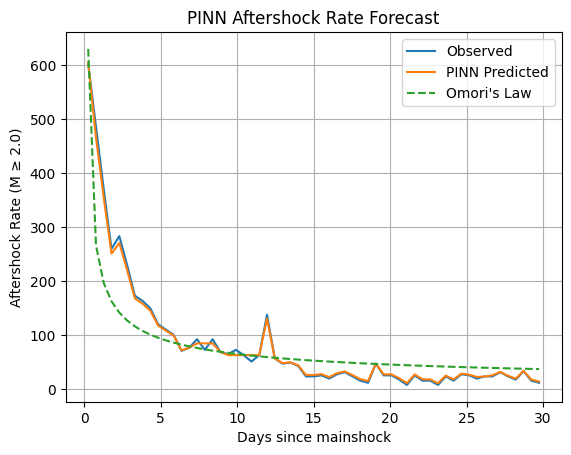

In [8]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== 1. Load and Prepare Aftershock Data =====
df = pd.read_csv("data.csv", parse_dates=["time"])
mainshock_time = pd.to_datetime("1994-01-17 12:30:00")
window_days = 30
magnitude_thresh = 2.0

aftershocks = df[
    (df["time"] > mainshock_time) &
    (df["time"] <= mainshock_time + pd.Timedelta(days=window_days)) &
    (df["magnitude"] >= magnitude_thresh)
].copy()

# Time since mainshock in days
aftershocks["t"] = (aftershocks["time"] - mainshock_time).dt.total_seconds() / (3600 * 24)

# ===== 2. Create Histogram of Observed Aftershock Rate =====
bins = np.linspace(0, window_days, 60)
hist_counts, bin_edges = np.histogram(aftershocks["t"], bins=bins)
t_mid = (bin_edges[:-1] + bin_edges[1:]) / 2  # centers

t_tensor = torch.tensor(t_mid, dtype=torch.float32).view(-1, 1)
rate_obs = torch.tensor(hist_counts / np.diff(bins), dtype=torch.float32).view(-1, 1)  # rate = count / interval

# ===== 3. Define PINN =====
class AftershockPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        # Learnable Omori parameters (optional)
        self.K = nn.Parameter(torch.tensor(10.0))
        self.c = nn.Parameter(torch.tensor(0.1))
        self.p = nn.Parameter(torch.tensor(1.1))

    def forward(self, t):
        return self.net(t)  # outputs lambda(t)

    def omori(self, t):
        return self.K / ((t + self.c) ** self.p)

# ===== 4. Training Setup =====
model = AftershockPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# ===== 5. Train Loop =====
epochs = 200000
lambda_phys = 0.1  # strength of physics constraint

for epoch in range(epochs):
    optimizer.zero_grad()
    
    pred_rate = model(t_tensor)
    
    # Omori constraint
    omori_rate = model.omori(t_tensor)
    loss_data = loss_fn(pred_rate, rate_obs)
    loss_phys = loss_fn(pred_rate, omori_rate)
    
    total_loss = loss_data + lambda_phys * loss_phys
    total_loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4f}, Data = {loss_data.item():.4f}, Phys = {loss_phys.item():.4f}")

# ===== 6. Plot Results =====
with torch.no_grad():
    pred = model(t_tensor).squeeze().numpy()
    omori = model.omori(t_tensor).squeeze().numpy()

plt.plot(t_mid, rate_obs.squeeze().numpy(), label="Observed")
plt.plot(t_mid, pred, label="PINN Predicted")
plt.plot(t_mid, omori, "--", label="Omori's Law")
plt.xlabel("Days since mainshock")
plt.ylabel("Aftershock Rate (M ≥ 2.0)")
plt.legend()
plt.title("PINN Aftershock Rate Forecast")
plt.grid()
plt.show()

Epoch 0, Loss = 0.6991, Data = 0.6991, Phys = 0.0000
Epoch 300, Loss = 0.4402, Data = 0.4402, Phys = 0.0000
Epoch 600, Loss = 0.4333, Data = 0.4333, Phys = 0.0000
Epoch 900, Loss = 0.4102, Data = 0.4102, Phys = 0.0001
Epoch 1200, Loss = 0.3367, Data = 0.3366, Phys = 0.0010
Epoch 1500, Loss = 0.2825, Data = 0.2824, Phys = 0.0007
Epoch 1800, Loss = 0.1502, Data = 0.1495, Phys = 0.0077
Epoch 2100, Loss = 0.0966, Data = 0.0960, Phys = 0.0053
Epoch 2400, Loss = 0.0581, Data = 0.0576, Phys = 0.0045
Epoch 2700, Loss = 0.0323, Data = 0.0320, Phys = 0.0027


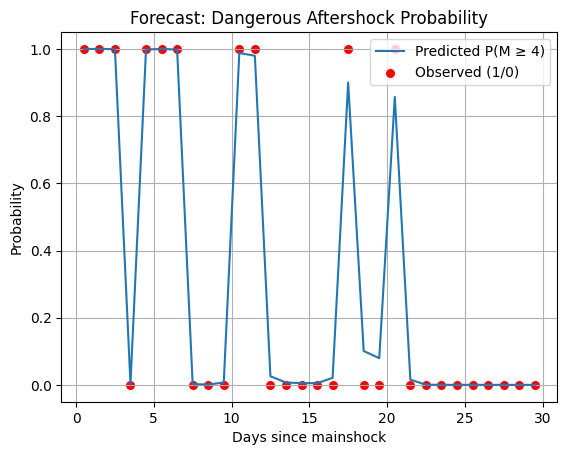

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# ==== Load Catalog ====
df = pd.read_csv("data.csv", parse_dates=["time"])
mainshock_time = pd.to_datetime("1994-01-17 12:30:00")
window_days = 30
mag_thresh = 4.0
bin_size = 1.0  # days

# ==== Filter Aftershocks ====
df = df[df["time"] > mainshock_time].copy()
df["t"] = (df["time"] - mainshock_time).dt.total_seconds() / (3600 * 24)

# ==== Bin Data and Assign Labels ====
bins = np.arange(0, window_days + bin_size, bin_size)
labels = []
t_centers = []

for i in range(len(bins) - 1):
    t0, t1 = bins[i], bins[i+1]
    subset = df[(df["t"] >= t0) & (df["t"] < t1)]
    label = int((subset["magnitude"] >= mag_thresh).any())
    labels.append(label)
    t_centers.append((t0 + t1) / 2)

t_tensor = torch.tensor(t_centers, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

# ==== Define PINN Model ====
class ProbPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, t):
        return self.net(t)

model = ProbPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bce = nn.BCELoss()

# ==== Train with Physics-Informed Loss ====
def physics_loss(prob, t):
    dP_dt = torch.autograd.grad(prob.sum(), t, create_graph=True)[0]
    # Penalize if dP/dt is not decreasing (inspired by Omori decay)
    penalty = torch.relu(dP_dt)  # want dP/dt <= 0
    return (penalty ** 2).mean()

lambda_phys = 0.1
epochs = 3000

for epoch in range(epochs):
    optimizer.zero_grad()
    t_tensor.requires_grad = True
    pred = model(t_tensor)
    loss_data = bce(pred, y_tensor)
    loss_phys = physics_loss(pred, t_tensor)
    loss = loss_data + lambda_phys * loss_phys
    loss.backward()
    optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4f}, Data = {loss_data.item():.4f}, Phys = {loss_phys.item():.4f}")

# ==== Plot the Result ====
with torch.no_grad():
    pred = model(t_tensor).squeeze().numpy()

plt.plot(t_centers, pred, label="Predicted P(M ≥ 4)")
plt.scatter(t_centers, y_tensor.squeeze().numpy(), label="Observed (1/0)", c="r", s=30)
plt.xlabel("Days since mainshock")
plt.ylabel("Probability")
plt.title("Forecast: Dangerous Aftershock Probability")
plt.grid()
plt.legend()
plt.show()

Epoch 0, Total Loss = 0.7786, Data = 0.7208, Phys = 0.5783
Epoch 300, Total Loss = 0.4604, Data = 0.4034, Phys = 0.5704
Epoch 600, Total Loss = 0.4364, Data = 0.3783, Phys = 0.5805
Epoch 900, Total Loss = 0.3776, Data = 0.3192, Phys = 0.5844
Epoch 1200, Total Loss = 0.2697, Data = 0.2110, Phys = 0.5868
Epoch 1500, Total Loss = 0.1558, Data = 0.0971, Phys = 0.5867
Epoch 1800, Total Loss = 0.0962, Data = 0.0371, Phys = 0.5914
Epoch 2100, Total Loss = 0.0738, Data = 0.0156, Phys = 0.5823
Epoch 2400, Total Loss = 0.0663, Data = 0.0085, Phys = 0.5788
Epoch 2700, Total Loss = 0.0631, Data = 0.0054, Phys = 0.5776

📊 Validation Metrics:
Accuracy       : 0.67
Precision      : 0.00
Recall         : 0.00
F1 Score       : 0.00
AUC (ROC)      : 0.40
Confusion Matrix:
[[4 1]
 [1 0]]


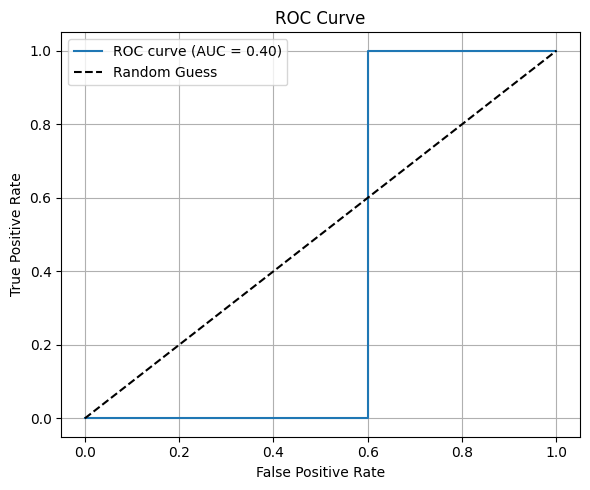

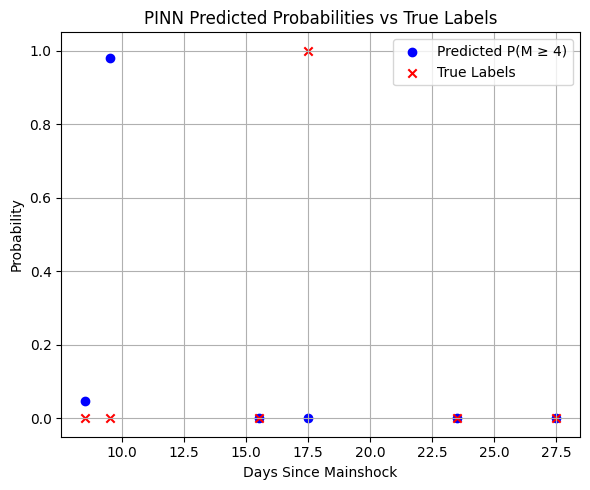

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_auc_score, roc_curve)

# ==== Load Catalog ====
df = pd.read_csv("data.csv", parse_dates=["time"])
mainshock_time = pd.to_datetime("1994-01-17 12:30:00")
window_days = 30
mag_thresh = 4.0
bin_size = 1.0  # days

# ==== Filter Aftershocks ====
df = df[df["time"] > mainshock_time].copy()
df["t"] = (df["time"] - mainshock_time).dt.total_seconds() / (3600 * 24)

# ==== Bin Data and Assign Labels ====
bins = np.arange(0, window_days + bin_size, bin_size)
labels = []
t_centers = []

for i in range(len(bins) - 1):
    t0, t1 = bins[i], bins[i + 1]
    subset = df[(df["t"] >= t0) & (df["t"] < t1)]
    label = int((subset["magnitude"] >= mag_thresh).any())
    labels.append(label)
    t_centers.append((t0 + t1) / 2)

t_all = torch.tensor(t_centers, dtype=torch.float32).view(-1, 1)
y_all = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

# ==== Split into Train/Test ====
t_train, t_test, y_train, y_test = train_test_split(t_all, y_all, test_size=0.2, random_state=42)

# ==== Define PINN Model ====
class ProbPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1), nn.Sigmoid()
        )

    def forward(self, t):
        return self.net(t)

model = ProbPINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
bce = nn.BCELoss()

# ==== Physics Loss (Omori Decay Shape Constraint) ====
def omori_loss(prob, t, p=1.2, c=0.1):
    dP_dt = torch.autograd.grad(prob.sum(), t, create_graph=True)[0]
    expected = -p / (t + c) ** (p + 1)
    return F.mse_loss(dP_dt, expected)

# ==== Train Loop ====
lambda_phys = 0.1

for epoch in range(3000):
    model.train()
    optimizer.zero_grad()
    t_train.requires_grad = True
    pred = model(t_train)

    loss_data = bce(pred, y_train)
    loss_phys = omori_loss(pred, t_train)
    loss = loss_data + lambda_phys * loss_phys
    loss.backward()
    optimizer.step()

    if epoch % 300 == 0:
        print(f"Epoch {epoch}, Total Loss = {loss.item():.4f}, Data = {loss_data.item():.4f}, Phys = {loss_phys.item():.4f}")

# ==== Validation ====
model.eval()
with torch.no_grad():
    y_probs = model(t_test).squeeze().numpy()
    y_pred = (y_probs >= 0.5).astype(int)
    y_true = y_test.squeeze().numpy()

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_probs)
cm = confusion_matrix(y_true, y_pred)

print("\n📊 Validation Metrics:")
print(f"Accuracy       : {acc:.2f}")
print(f"Precision      : {prec:.2f}")
print(f"Recall         : {rec:.2f}")
print(f"F1 Score       : {f1:.2f}")
print(f"AUC (ROC)      : {auc:.2f}")
print("Confusion Matrix:")
print(cm)

# ==== Plot ROC Curve ====
fpr, tpr, _ = roc_curve(y_true, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ==== Probability Plot ====
plt.figure(figsize=(6, 5))
plt.scatter(t_test.squeeze().numpy(), y_probs, label="Predicted P(M ≥ 4)", color='blue')
plt.scatter(t_test.squeeze().numpy(), y_true, label="True Labels", color='red', marker='x')
plt.title("PINN Predicted Probabilities vs True Labels")
plt.xlabel("Days Since Mainshock")
plt.ylabel("Probability")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from geopy.distance import geodesic

def generate_training_dataset(
    catalog_df,
    mainshock_mag_thresh=6.0,
    aftershock_mag_thresh=4.0,
    time_window_days=30,
    bin_size_days=1.0,
    spatial_radius_km=100.0
):
    # Ensure datetime and numeric types
    catalog_df["time"] = pd.to_datetime(catalog_df["time"])
    catalog_df["magnitude"] = catalog_df["magnitude"].astype(float)
    catalog_df["latitude"] = catalog_df["latitude"].astype(float)
    catalog_df["longitude"] = catalog_df["longitude"].astype(float)

    # Step 1: Identify mainshocks
    mainshocks = catalog_df[catalog_df["magnitude"] >= mainshock_mag_thresh].sort_values("time")

    # Collect all (t, m_ms, label) samples
    training_rows = []

    for _, ms in mainshocks.iterrows():
        ms_time = ms["time"]
        ms_mag = ms["magnitude"]
        ms_latlon = (ms["latitude"], ms["longitude"])

        # Time filter
        t_start = ms_time
        t_end = ms_time + timedelta(days=time_window_days)
        window_df = catalog_df[(catalog_df["time"] > t_start) & (catalog_df["time"] <= t_end)].copy()

        # Spatial filter
        window_df["distance_km"] = window_df.apply(
            lambda row: geodesic((row["latitude"], row["longitude"]), ms_latlon).km, axis=1
        )
        window_df = window_df[window_df["distance_km"] <= spatial_radius_km]
        window_df["t_since_mainshock"] = (window_df["time"] - ms_time).dt.total_seconds() / (3600 * 24)

        # Binning and labeling
        bins = np.arange(0, time_window_days + bin_size_days, bin_size_days)
        for i in range(len(bins) - 1):
            t0, t1 = bins[i], bins[i+1]
            t_center = (t0 + t1) / 2
            bin_events = window_df[(window_df["t_since_mainshock"] >= t0) & (window_df["t_since_mainshock"] < t1)]
            label = int((bin_events["magnitude"] >= aftershock_mag_thresh).any())

            training_rows.append({
                "t_bin_center": t_center,
                "mainshock_time": ms_time,
                "m_ms": ms_mag,
                "bin_start_time": ms_time + timedelta(days=t0),
                "aftershock_label": label
            })

    return pd.DataFrame(training_rows)